## 1. Sentiment Analysis en Texto

El análisis de emociones o sentimientos se refiere al proceso de extraer información acerca de la actitud
que una persona (o grupo de ellas) manifiesta, en un determinado medio o formato digital, con respecto a un
tópico o contexto de comunicación. Uno de los casos más estudiados corresponde a determinar la polaridad
de un trozo de texto, es decir, clasificar una determinada evaluación escrita (*review*), en que una persona
manifiesta una opinión, como *positiva*, *negativa* o *neutral*. Esto también ha sido extendido a otros medios, como lo es analizar la polaridad de textos en redes sociales.  La dificultad de este problema radica en el carácter altamente ambiguo e informal del lenguaje que utilizan naturalmente las personas ası́ como el manejo de negaciones, sarcasmo y abreviaciones en una frase.

<img src="https://formtitanhelpdeskimage.s3.amazonaws.com/70c78f9df2fd5c130e7021644f78f4c5.jpg" title="Title text" width="40%" />

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ftr = open("train_data.csv", "r",  encoding="ISO-8859-1")
rows = [line.split(" ",1) for line in ftr.readlines()]
df_train = pd.DataFrame(rows, columns=['Sentiment','Text'])
df_train['Sentiment'] = (pd.to_numeric(df_train['Sentiment'])+1)/2 # 0 o 1

fts = open("test_data.csv", "r",  encoding="ISO-8859-1")
rows2 = [line.split(" ",1) for line in fts.readlines()]
df_test = pd.DataFrame(rows2, columns=['Sentiment','Text'])
df_test['Sentiment'] = (pd.to_numeric(df_test['Sentiment'])+1)/2 # 0 o 1


df_train_text = df_train.Text
df_test_text = df_test.Text
labels_train = df_train.Sentiment.values
labels_test = df_test.Sentiment.values

> a) Describa los datos trabajados, como la cantidad de datos en cada conjunto, largo de los textos, la cantidad de ejemplo por cada clase, o alguna otra forma que piense que pueda ser útil para comprender el problema trabajado.


In [134]:
df_train

,Sentiment,Text
0,0.0,"everything's serious , poetic , earnest and --..."
1,0.0,"narratively , trouble every day is a plodding ..."
2,1.0,a truly wonderful tale combined with stunning ...
3,1.0,jason patric and ray liotta make for one splen...
4,0.0,haneke keeps us at arm's length . guided more ...
...,...,...
3549,0.0,it takes a strange kind of laziness to waste t...
3550,0.0,"an easy watch , except for the annoying demean..."
3551,1.0,dog soldiers doesn't transcend genre -- it emb...
3552,0.0,it uses the pain and violence of war as backgr...


Se nos entregan dos conjuntos de datos, el conjunto de entrenamiento con 3554 opiniones, en donde 1770 opiniones son positivas y 1784 opiniones negativas. Al mismo tiempo existe un conjunto de test con 3554 opiniones, al igual que el conjunto anterior, repartiendose en 1751 opiniones positivas y 1803 negativas.

> b) Construya un conjunto de validación desde el conjunto de entrenamiento para seleccionar modelos. Decida el tamaño dada la cantidad de ejemplos que se tienen para entrenamiento.

In [128]:
from sklearn.model_selection import train_test_split
df_train_text, df_val_text, labels_train, labels_val = train_test_split(df_train_text, labels_train, test_size= 0.2, random_state=0)

Se crea un conjunto de validacion el cual se utilizara mas adelante, este utiliza el 20% de los datos del conjunto de entrenamiento mencionado anteriormente, lo que es equivalente a 711 opiniones.

> c) Realice un pre-procesamiento a los textos para normalizar un poco su estructura, para ello utilice el código de ejemplo a continuación, donde se pasa el texto a minúsculas (*lower-casing*), se reducen las mútliples letras, se eliminan palabras sin significados como artículos, pronombres y preposiciones (*stop word removal* [[3]](#refs)), además de pasar las palabras a su tronco léxico con la técnica de *lemmatizer* [[4]](#refs). Comente la importancia de un correcto pre-procesamiento en el domino de lenguaje natural.

In [129]:
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
def base_word(word):
    wordlemmatizer = WordNetLemmatizer()
    return wordlemmatizer.lemmatize(word) 
def word_extractor(text):
    commonwords = stopwords.words('english')
    #commonwords.remove('not')
    text = re.sub(r'([a-z])\1+', r'\1\1',text) #substitute multiple letter by two
    words = ""
    wordtokens = [ base_word(word.lower()) for word in word_tokenize(text) ]
    for word in wordtokens:
        if word not in commonwords: #delete stopwords
            words+=" "+word
    return words
... #try yourself
word_extractor("I love to eat cake")
word_extractor("I love eating cake")
word_extractor("I loved eating the cake")
word_extractor("I do not love eating cake")
word_extractor("I don't love eating cake")
... #try yourself
texts_train = [word_extractor(text) for text in df_train_text]
texts_val = [word_extractor(text) for text in df_val_text]
texts_test = [word_extractor(text) for text in df_test_text]


original_train_set = np.concatenate((texts_train, texts_val))       #Formamos el arreglo de entrenamiento original
original_labels_train = np.concatenate((labels_train, labels_val))



Dada la complejidad de lenguaje natural humano, se busca que este sea lo mas similar al conocido por la computadora, en donde se eliminan y arreglan palabras las cuales podrian no ser correctamente entendidas por un programa y que no pertenecescan a un vocabulario comun (o del diccionario), es por esto que es necesario eliminar todo tipo de error tipografico que haya realizado el creador del comentario. Por otro lado, dado que se intenta eitquetar en oraciones positivas y negativas, se elimina todo aquello que no aporta semanticamente en la busqueda de positividad o negatividad en un comentario.

> d) Construya una representación vectorial a los textos de entrada para poder ser manejados y clasificados por los modelos de aprendizaje. Para ésto utilice el tipo de característica más común, que consiste en contar cuántas veces aparece cada términos/palabras en el texto, denominado **TF** (*term-frequency*). Para esto, se necesita contar con un vocabulario base, el cual se construirá a través de la unión de todas las palabras que observemos en los textos de entrenamiento ¿Cuáles son las palabras más frecuentes?

In [130]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 1), binary=False) #TF representation
vectorizer.fit(texts_train)

features_train = vectorizer.transform(texts_train)


features_val = vectorizer.transform(texts_val)


features_test = vectorizer.transform(texts_test)

original_features_train = vectorizer.transform(original_train_set)

vocab = vectorizer.get_feature_names()
dist=list(np.array(features_train.sum(axis=0)).reshape(-1,))

> e) Para tener una visión distinta y entender mejor la representación vectorial realizada, visualice los datos en un plano 2D. Para ésto utilice la técnica **LSA** (*Latent Semantic Analysis*) [[5]](#refs) que a diferencia de PCA, **no centra** los datos antes de realizar la descomposicipon SVD, de ésta manera podrá visualizar el espacio semántico de "conceptos" latentes usados en la representación. Coloree cada texto en base a su clase ¿Qué indica lo observado? Comente e interprete los resultados

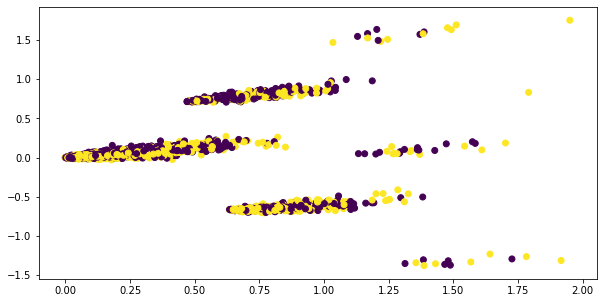

In [6]:
from sklearn.decomposition import TruncatedSVD

model = TruncatedSVD(n_components=2)
model.fit(features_train)
x_plot = model.transform(features_train)
plt.figure(figsize=(10,5))
plt.scatter(x_plot[:,0], x_plot[:,1], c=labels_train)
plt.show()


> f) Entrene un modelo de Regresión Logística Regularizado (utilizando como penalizador la norma $l_2$). Varíe el parámetro de regularización $C$, en potencias de 10, midiendo el error de predicción obtenido sobre los datos de entrenamiento y validación, construya un gráfico que muestre la variación de ambos errores respecto al parámetro $C$. Explique el significado y valor esperado del parámetro de regularización.

In [127]:
from sklearn.linear_model import LogisticRegression

def do_LOGIT(x,y,xv,yv, param):
    print("Param C= ",param)
    model= LogisticRegression(solver = 'liblinear')
    model.set_params(C=param)
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc
Cs = [10**i for i in np.arange(-4.0, 4.0)]


Logit_models = []
logit_train_accs =[]
logit_test_accs =[]

for i in Cs:
    model, train_acc, test_acc = do_LOGIT(x = features_train, y = labels_train, xv = features_val, yv = labels_val, param = i)
    
    Logit_models.append(model)
    logit_train_accs.append(train_acc)
    logit_test_accs.append(test_acc)

    print("Train_acc = ", train_acc)
    print("Test_acc = ", test_acc)
    
    print('*' * 100)
     
plt.plot(np.arange(-4.0, 4.0), logit_train_accs)
plt.plot(np.arange(-4.0, 4.0), logit_test_accs)


Param C=  0.0001


ValueError: Found input variables with inconsistent numbers of samples: [5550, 711]

> g) Entrene una Máquina de Soporte Vectorial (SVM) con distintos kernels. Similar a lo anterior, construya un gráfico que muestre la variación de ambos errores respecto al parámetro de regularización $C$ para cada tipo de kernel que experimente. Explique el significado y valor esperado de los parámetros en este modelo.

Param C=  0.0001 Kernel=  linear
Train_acc =  0.5001758705592684
Test_acc =  0.509142053445851
****************************************************************************************************
Param C=  0.001 Kernel=  linear
Train_acc =  0.5001758705592684
Test_acc =  0.509142053445851
****************************************************************************************************
Param C=  0.01 Kernel=  linear
Train_acc =  0.7502638058389026
Test_acc =  0.6371308016877637
****************************************************************************************************
Param C=  0.1 Kernel=  linear
Train_acc =  0.9497010200492437
Test_acc =  0.6919831223628692
****************************************************************************************************
Param C=  1.0 Kernel=  linear
Train_acc =  0.9989447766443897
Test_acc =  0.6891701828410689
****************************************************************************************************
Param C=  10.0 Kernel=  li

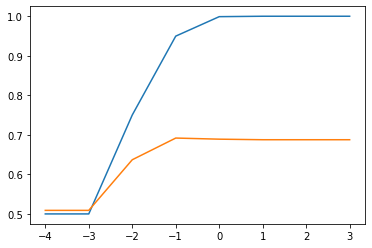

In [8]:
from sklearn.svm import SVC as SVM #SVC is for classification
def do_SVM(x,y,xv,yv, param, kernel='linear'):
    print("Param C= ",param, 'Kernel= ', kernel)
    model= SVM()
    model.set_params(C=param,kernel=kernel) #try rbf and linear at least
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc
Cs = [10**i for i in np.arange(-4.0,4.0)]

SVM_models = []
SVM_train_accs =[]
SVM_test_accs =[]

for i in Cs:
    model, train_acc, test_acc = do_SVM(x = features_train, y = labels_train, xv = features_val, yv = labels_val, param = i)
    
    SVM_models.append(model)
    SVM_train_accs.append(train_acc)
    SVM_test_accs.append(test_acc)
    
    print("Train_acc = ", train_acc)
    print("Test_acc = ", test_acc)
    
    print('*' * 100)

plt.plot(np.arange(-4.0, 4.0), SVM_train_accs)
plt.plot(np.arange(-4.0, 4.0), SVM_test_accs)

> h) Utilice el algoritmo de similaridad k-NN para intentar resolver el problema. Varíe el parámetro de los vecinos $k$ en un rango que estime conveniente y realice graficos de errores como en las preguntas anteriores. Comente sobre el valor esperado de este parámetro.


Param K=  1
Param K=  41
Param K=  81
Param K=  121
Param K=  161
Param K=  201
Param K=  241
Param K=  281
Param K=  321
Param K=  361
Param K=  401
Param K=  441
Param K=  481
Param K=  521
Param K=  561
Param K=  601
Param K=  641
Param K=  681
Param K=  721
Param K=  761
Param K=  801
Param K=  841
Param K=  881
Param K=  921
Param K=  961
Param K=  1001
Param K=  1041
Param K=  1081
Param K=  1121
Param K=  1161
Param K=  1201
Param K=  1241
Param K=  1281
Param K=  1321
Param K=  1361
Param K=  1401
Param K=  1441
Param K=  1481
Param K=  1521
Param K=  1561
Param K=  1601
Param K=  1641
Param K=  1681
Param K=  1721
Param K=  1761
Param K=  1801
Param K=  1841
Param K=  1881
Param K=  1921
Param K=  1961
Param K=  2001
Param K=  2041
Param K=  2081
Param K=  2121
Param K=  2161
Param K=  2201
Param K=  2241
Param K=  2281
Param K=  2321
Param K=  2361
Param K=  2401
Param K=  2441
Param K=  2481
Param K=  2521
Param K=  2561
Param K=  2601
Param K=  2641
Param K=  2681
Param K= 

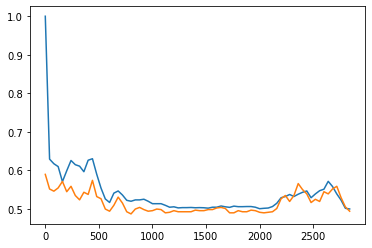

In [9]:
from sklearn.neighbors import KNeighborsClassifier
def do_KNN(x,y,xv,yv, param):
    model = KNeighborsClassifier()
    print("Param K= ",param)
    model.set_params(n_neighbors=param)
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc
Ks = np.arange(1, features_train.shape[0], 40)

KNN_train_accs =[]
KNN_test_accs =[]

for i in Ks:
    model, train_acc, test_acc = do_KNN(x = features_train, y = labels_train, xv = features_val, yv = labels_val, param = i)
    KNN_train_accs.append(train_acc)
    KNN_test_accs.append(test_acc)
    
plt.plot(Ks, KNN_train_accs)
plt.plot(Ks, KNN_test_accs)

> i) Entrene un Arbol de Decisión para resolver el problema. Varíe los parámetros de *max depth* y *min samples split* de manera separada, constuyendo gráficos de error respecto a estos parámetros. *Los valores que se presentan son sugerencias, no es necesario utilizar los mismos*. Comente sobre la diferencia entre la selección de estos dos parámetros.


Param Max-D=  1 Min-samples-S=  20
Param Max-D=  151 Min-samples-S=  20
Param Max-D=  301 Min-samples-S=  20
Param Max-D=  451 Min-samples-S=  20
Param Max-D=  601 Min-samples-S=  20
Param Max-D=  751 Min-samples-S=  20
Param Max-D=  901 Min-samples-S=  20
Param Max-D=  1051 Min-samples-S=  20
Param Max-D=  1201 Min-samples-S=  20
Param Max-D=  1351 Min-samples-S=  20
Param Max-D=  1501 Min-samples-S=  20
Param Max-D=  1651 Min-samples-S=  20
Param Max-D=  1801 Min-samples-S=  20
Param Max-D=  1951 Min-samples-S=  20
Param Max-D=  2101 Min-samples-S=  20
Param Max-D=  2251 Min-samples-S=  20
Param Max-D=  2401 Min-samples-S=  20
Param Max-D=  2551 Min-samples-S=  20
Param Max-D=  2701 Min-samples-S=  20
Param Max-D=  2851 Min-samples-S=  20
Param Max-D=  3001 Min-samples-S=  20
Param Max-D=  3151 Min-samples-S=  20
Param Max-D=  3301 Min-samples-S=  20
Param Max-D=  3451 Min-samples-S=  20
Param Max-D=  3601 Min-samples-S=  20
Param Max-D=  3751 Min-samples-S=  20
Param Max-D=  3901 Mi

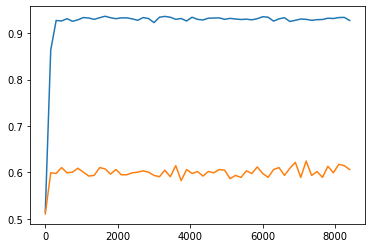

In [10]:
from sklearn.tree import DecisionTreeClassifier as Tree
import ipywidgets as widgets
from ipywidgets import interact

def do_Tree(x,y,xv,yv, param_d=None, param_m=2):
    model= Tree()
    print("Param Max-D= ",param_d, 'Min-samples-S= ', param_m)
    model.set_params(max_depth=param_d, min_samples_split=param_m) 
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc
Depths = np.arange(1, features_train.shape[1], 150 ) #choose steps
SamplesS = np.arange(2, features_train.shape[0] , 10 ) #choose steps

CT_train_accs =[]
CT_test_accs =[]

for i in Depths:
    model, train_acc, test_acc = do_Tree(x = features_train, y = labels_train, xv = features_val, yv = labels_val, param_d = i, param_m = 20)
    CT_train_accs.append(train_acc)
    CT_test_accs.append(test_acc)

plt.plot(Depths, CT_train_accs)
plt.plot(Depths, CT_test_accs)

Param Max-D=  100 Min-samples-S=  2
Param Max-D=  100 Min-samples-S=  12
Param Max-D=  100 Min-samples-S=  22
Param Max-D=  100 Min-samples-S=  32
Param Max-D=  100 Min-samples-S=  42
Param Max-D=  100 Min-samples-S=  52
Param Max-D=  100 Min-samples-S=  62
Param Max-D=  100 Min-samples-S=  72
Param Max-D=  100 Min-samples-S=  82
Param Max-D=  100 Min-samples-S=  92
Param Max-D=  100 Min-samples-S=  102
Param Max-D=  100 Min-samples-S=  112
Param Max-D=  100 Min-samples-S=  122
Param Max-D=  100 Min-samples-S=  132
Param Max-D=  100 Min-samples-S=  142
Param Max-D=  100 Min-samples-S=  152
Param Max-D=  100 Min-samples-S=  162
Param Max-D=  100 Min-samples-S=  172
Param Max-D=  100 Min-samples-S=  182
Param Max-D=  100 Min-samples-S=  192
Param Max-D=  100 Min-samples-S=  202
Param Max-D=  100 Min-samples-S=  212
Param Max-D=  100 Min-samples-S=  222
Param Max-D=  100 Min-samples-S=  232
Param Max-D=  100 Min-samples-S=  242
Param Max-D=  100 Min-samples-S=  252
Param Max-D=  100 Min-s

Param Max-D=  100 Min-samples-S=  2292
Param Max-D=  100 Min-samples-S=  2302
Param Max-D=  100 Min-samples-S=  2312
Param Max-D=  100 Min-samples-S=  2322
Param Max-D=  100 Min-samples-S=  2332
Param Max-D=  100 Min-samples-S=  2342
Param Max-D=  100 Min-samples-S=  2352
Param Max-D=  100 Min-samples-S=  2362
Param Max-D=  100 Min-samples-S=  2372
Param Max-D=  100 Min-samples-S=  2382
Param Max-D=  100 Min-samples-S=  2392
Param Max-D=  100 Min-samples-S=  2402
Param Max-D=  100 Min-samples-S=  2412
Param Max-D=  100 Min-samples-S=  2422
Param Max-D=  100 Min-samples-S=  2432
Param Max-D=  100 Min-samples-S=  2442
Param Max-D=  100 Min-samples-S=  2452
Param Max-D=  100 Min-samples-S=  2462
Param Max-D=  100 Min-samples-S=  2472
Param Max-D=  100 Min-samples-S=  2482
Param Max-D=  100 Min-samples-S=  2492
Param Max-D=  100 Min-samples-S=  2502
Param Max-D=  100 Min-samples-S=  2512
Param Max-D=  100 Min-samples-S=  2522
Param Max-D=  100 Min-samples-S=  2532
Param Max-D=  100 Min-sam

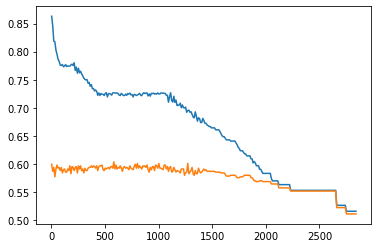

In [11]:
CT_train_accs =[]
CT_test_accs =[]

for i in SamplesS:
    model, train_acc, test_acc = do_Tree(x = features_train, y = labels_train, xv = features_val, yv = labels_val, param_d = 100, param_m = i)
    CT_train_accs.append(train_acc)
    CT_test_accs.append(test_acc)

plt.plot(SamplesS, CT_train_accs)
plt.plot(SamplesS, CT_test_accs)

> j) Utilice una Red Neuronal Artificial (ANN) para intentar resolver el problema, como la que se señala a continuación (utilizando el framework de *keras*): entrenada por 25 iteraciones al dataset (*epochs*) con un tamaño de *batch* de 128 para las actualizaciones de los pesos, utilizando *SGD* con una tasa de aprendizaje $0.1$ sobre la función de pérdida binaria de clasificación. La arquitectura de la red contiene una capa de salida con una única neurona que indica la probabilidad de que el texto sea positivo, una capa escondida con número de neuronas $N_h$ y la capa de entrada implícita para $x$. Varíe el parámetro que corresponde al número de neuronas en la capa oculta $N_h$, en potencias de 2, y vuelva a realizar el gráfico de error con respecto al parámetro. Comente.


Using TensorFlow backend.


Neuron hidden =  2
Train_acc =  0.5501230955123901
Test_acc =  0.5330520272254944
****************************************************************************************************
Neuron hidden =  4
Train_acc =  0.7449876666069031
Test_acc =  0.646976113319397
****************************************************************************************************
Neuron hidden =  8
Train_acc =  0.7077031135559082
Test_acc =  0.6160337328910828
****************************************************************************************************
Neuron hidden =  16
Train_acc =  0.6345409750938416
Test_acc =  0.5639943480491638
****************************************************************************************************
Neuron hidden =  32
Train_acc =  0.5648962259292603
Test_acc =  0.5091420412063599
****************************************************************************************************
Neuron hidden =  64
Train_acc =  0.7530777454376221
Test_acc =  0.6244725584983826
*

([<matplotlib.axis.XTick at 0x2850a94cb70>,
 <a list of 9 Text xticklabel objects>)

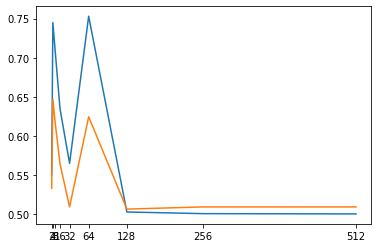

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
def do_ANN(x,y, xv,yv, param):
    print("Neuron hidden = ",param)
    model = Sequential()
    model.add(Dense(units=param, input_dim=x.shape[1], activation="sigmoid"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(x, y, epochs=25, batch_size=128, verbose=0)
    train_acc = model.evaluate(x,y, verbose=0)[1] #in position 0 is the loss
    test_acc = model.evaluate(xv,yv, verbose=0)[1]
    return model, train_acc, test_acc
N_h = [2**i for i in range(1,10)]


ANN_train_accs =[]
ANN_test_accs =[]

for i in N_h:
    model, train_acc, test_acc = do_ANN(x = features_train, y = labels_train, xv = features_val, yv = labels_val, param = i)
    ANN_train_accs.append(train_acc)
    ANN_test_accs.append(test_acc)
    
    print("Train_acc = ", train_acc)
    print("Test_acc = ", test_acc)
    
    print('*' * 100)


plt.plot(N_h, ANN_train_accs)
plt.plot(N_h, ANN_test_accs)
plt.xticks(N_h)

> k) Ahora evalúe sobre el conjunto de pruebas el mejor modelo obtenido, seleccionado en base a la métrica de desempeño en el conjunto de validación. Comente sobre la calidad obtenida en el problema trabajado ¿Es un buen valor? ¿Cuál podría ser un valor de referencia?

In [13]:
model, train_acc, test_acc = do_LOGIT(x = original_features_train, y = original_labels_train, xv = features_test, yv = labels_test, param = 1)
print("Train_acc = ", train_acc)
print("Test_acc = ", test_acc)

Param C=  1
Train_acc =  0.9850872256612268
Test_acc =  0.7228474957794034


> l) Para comparar sus resultados utilice el modelo VADER (*Valence Aware Dictionary and sEntiment Reasoner*) [[6]](#refs), el cual entrega una *score* de predicción a nivel léxico (de palabras que comúnmente se asocian a una orientiación positiva o negativa). Este modelo construido manualmente no requiere entrenamiento, por lo que solo debe evaluar en conjunto de pruebas realizando predicciones del texto bruto (sin pre-procesamiento). Comente.


In [14]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
def vader_predict(sentences): 
    sid_obj = SentimentIntensityAnalyzer() 
    sent_v = []
    for text in sentences:
        sentiment_dict = sid_obj.polarity_scores(text) 
        if sentiment_dict["pos"] > sentiment_dict["neg"]: #based on scores
            sent_v.append(1)
        else:
            sent_v.append(0)
    return np.asarray(sent_v)
vader_pred_test = vader_predict(df_test_text) 
from sklearn.metrics import accuracy_score
accuracy_score(labels_test, vader_pred_test)

0.6359032076533483

> m) Bajo la idea del modelo VADER realice un análisis de qué palabras su modelo tiende a considerar como positivas o negativas por si solas. Algunos de los modelos estudiados en esta sección realizan una predicción probabilista, utilice uno de éstos para verificar lo solicitado. Sobre la representación *TF* genere datos de entradas que contengan una sola palabra del vocabulario para evaluar que predicción les genera su modelo a esas palabras. Muestre las palabras más negativas y positivas en el vocabulario consideradas por su modelo. Comente.


In [15]:
V = len(vocab)
word_scores = np.zeros((V, 2))
for i in range(V):
    x_word = np.zeros((1, V))
    x_word[:,i] = 1 # only the "i" word appeared
    word_scores[i] = model.predict_proba(x_word)  #devuelve [proba de que sea 0, proba de que sea 1]
    
indexes = np.argmax(word_scores, axis = 0)

print('Most negative Word:', vocab[indexes[0]]+ ', prob:', word_scores[indexes[0]][0])
print('Most positive Word:', vocab[indexes[1]]+ ', prob:', word_scores[indexes[1]][1])

neg=[]
pos=[]
for i in range(10):
    indexes = np.argmax(word_scores, axis = 0)
    neg.append(vocab[indexes[0]])
    pos.append(vocab[indexes[1]])
    vocab.pop(indexes[0])
    vocab.pop(indexes[1]-1)

print('*'*100)
# 
print("Conjunto de palabras positivas:")
print(pos)

print("Conjunto de palabras negativas:")
print(neg)


Most negative Word: worst, prob: 0.8508366513541293
Most positive Word: solid, prob: 0.8230236008390955
****************************************************************************************************
Conjunto de palabras positivas:
['solid', 'solidly', 'solipsism', 'solo', 'solondz', 'solondzian', 'somber', 'some', 'somebody', 'somehow']
Conjunto de palabras negativas:
['worst', 'worthless', 'worthy', 'wound', 'wounding', 'wow', 'wrapped', 'wreaked', 'wreckage', 'wrenching']


> n) Intente mejorar los resultados de otra manera. Varíe el pre-procesamiento realizado a los datos en c), por ejemplo eliminar símbolos, números o aplicar la técnica de *stemmming* [[7]](#refs) en lugar de *lemmatization* para llevar a su tronco léxico.


In [123]:
from nltk.stem.porter import PorterStemmer
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize


df_train_text = df_train.Text
df_test_text = df_test.Text
labels_train = df_train.Sentiment.values
labels_test = df_test.Sentiment.values


def base_word(word):
    wordstemmer = PorterStemmer()
    return wordstemmer.stem(word)
def word_extractor(text):
    commonwords = stopwords.words('english')
    commonwords.remove('not')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    text = re.sub(r'[1-9]', r'',text)#delete numbers
    text = re.sub(r'[^A-Za-z0-9 ]+', r'',text)#delete numbers

    words = ""
    wordtokens = [ base_word(word.lower()) for word in word_tokenize(text) ]
    for word in wordtokens:
        if word not in commonwords: #delete stopwords
            words+=" "+word
    return words
... #try yourself

word_extractor("I love to eat cake"),
word_extractor("I love eating cake"),
word_extractor("I loved eating the cake"),
word_extractor("I do not love eating cake"),
word_extractor("I don't love eating cake")
... #try yourself

texts_train = [word_extractor(text) for text in df_train_text]
texts_test = [word_extractor(text) for text in df_test_text]

features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)

model, train_acc, test_acc = do_LOGIT(x = features_train, y = labels_train, xv = features_test, yv = labels_test, param = 1)
print("Train_acc = ", train_acc)
print("Test_acc = ", test_acc)

Param C=  1
Train_acc =  0.8922341024198087
Test_acc =  0.6783905458638154


Realizando una modificacion del extractor de palabras se obtiene que la eliminacion tanto de los numeros como los simbolos no mejoran el algoritmo, dado que originalmente se tenia Test_acc =  0.6924592009003939, el cual al aplicar la eliminacion de numeros (Test_acc =  0.6902082160945414) y de simbolos (Test_acc =  0.6775464265616207) se obtiene Test_acc =  0.6783905458638154.

En resumen, para este caso el eliminar símbolos y números provoca un empeoramiento en el desempeño.

> o) Varíe la representación utilizada actualmente por alguna otra que ayude a mejorar el desempeño, por ejemplo reducir el peso de una palabra si es que aparece en muchos textos: TF-IDF. Existen varias opciones que podría realizar para mejorar el desempeño, por ejemplo reducir el vocabulario a las $K$ palabras más frecuentes, eliminar las palabras menos frecuentes, normalizar la representación, utilizar *n-gramas*, entre otras.


In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer(binary=False, ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, norm='l2', use_idf=True, sublinear_tf=False)
tfidf_model.fit(texts_train)

features_train_final = tfidf_model.transform(texts_train)
features_test_final = tfidf_model.transform(texts_test)

vocab = tfidf_model.get_feature_names()
dist=list(np.array(features_train.sum(axis=0)).reshape(-1,))

model, train_acc, test_acc = do_LOGIT(x = features_train_final, y = labels_train, xv = features_test_final, yv = labels_test, param = 1)
print("Train_acc = ", train_acc)
print("Test_acc = ", test_acc)



#Reducir a las K palabras más frecuentes en caso de tener tiempo

Param C=  1
Train_acc =  0.9223410241980866
Test_acc =  0.7507034327518289


Al utilizar esta nueva representación obtenemos una mejora de desempeño notable.

> p) Utilice métricas auxiliares para entender en qué falla su mejor modelo obtenido hasta el momento. ¿La información entregada indica cómo se podría mejorar o cual sería la causa de la falla?


In [64]:
from sklearn.metrics import classification_report
def score_the_model(model, x, y):
    print("Detailed Analysis Testing Results ...")
    print(classification_report(y, model.predict(x), target_names=['negative opinion','positive opinion']))
score_the_model(model, features_test_final, labels_test )

#Precision – Accuracy of positive predictions. = TP/(TP + FP)
#Recall – Recall: Fraction of positives that were correctly identified. = TP/(TP+FN)
#F1 score – What percent of positive predictions were correct? = 2*(Recall * Precision) / (Recall + Precision)

#TN / True Negative: when a case was negative and predicted negative
#TP / True Positive: when a case was positive and predicted positive
#FN / False Negative: when a case was positive but predicted negative
#FP / False Positive: when a case was negative but predicted positive

Detailed Analysis Testing Results ...
                  precision    recall  f1-score   support

negative opinion       0.75      0.76      0.76      1803
positive opinion       0.75      0.74      0.75      1751

        accuracy                           0.75      3554
       macro avg       0.75      0.75      0.75      3554
    weighted avg       0.75      0.75      0.75      3554



Lo que se nos entrega a través de la función 'classification_report', es un análisis de falsos/verdaderos positivos y negativos. Para este caso, esta información no nos entrega pistas sobre como se podría mejorar o cuál sería la causa de alguna falla.

> q) Algo que se puede modificar en algunos modelos de aprendizaje es poner peso en cada una de las clases, por ejemplo si una clase es de mayor interés que las otras e interesa reducir más su error. En *sklearn* ésto puede ser realizado con el parámetro de *class_weights*. Por ejemplo, asigne que detectar los textos negativos me interesa 5 veces más que detectar los textos positivos. Comente.

In [65]:
classes_weights = {0: 5, 1: 1} #or choose..
model.set_params(class_weight=classes_weights)
model.fit(features_train_final, labels_train)
score_the_model(model, features_test_final, labels_test)

Detailed Analysis Testing Results ...
                  precision    recall  f1-score   support

negative opinion       0.55      0.99      0.71      1803
positive opinion       0.92      0.18      0.30      1751

        accuracy                           0.59      3554
       macro avg       0.74      0.58      0.50      3554
    weighted avg       0.73      0.59      0.51      3554



Al otorgarle mayor peso a las predicciones negativas, se obtiene un resultado bastante interesante. Del apartado anterior, dijimos que *recall* corresponde a la *'fracción de positivos que fueron correctamente identificados'*. En este caso para las opiniones negativas se obtuvo un valor del **99%**, esto significa que, del total de predicciones de opiniones negativas que hizo el modelo, el **99% estuvo correcto**. Sin embargo esto tiene un inconveniente, ya que se pierde *precision* en opiniones negativas (predecir negativa una opinion positiva) y sobre todo se pierde mucho *recall* en opiniones positivas, este es solo de **18%**. En conclusión, esta característica serviría solamente si estamos dispuestos a sacrificar las opiniones positivas.

> r) Visualice la clasificación que realiza su mejor modelo sobre algunos textos de pruebas ¿Qué entega mas información, una predicción categórica o una continua? ¿Cuál podría ser el beneficio de una o de otra? Comente


In [66]:
classes_weights = {0: 1, 1: 1} #or choose..
model.set_params(class_weight=classes_weights)
model.fit(features_train_final, labels_train)

test_pred = model.predict_proba(features_test_final) #or ".predict"
spl = np.random.randint( 0, len(test_pred), size=15)
for text, pred_s, true_s in zip(df_test_text[spl], test_pred[spl], labels_test[spl]):
    if true_s == 0.0:
        true_s = 'Negative'
    else:
        true_s = 'Positive'
    if pred_s[0]<pred_s[1]:
        pred_s = 'Positive, prob: ' + str(pred_s[1])#para que se vea mas bonito
    else:
        pred_s = 'Negative, prob: ' + str(pred_s[0])
    
    print("True sent: ", true_s, "-- Pred sent: ",pred_s)
    print("Raw text: ", text)


True sent:  Negative -- Pred sent:  Negative, prob: 0.6400575762568838
Raw text:  yet another movie which presumes that high school social groups are at war , let alone conscious of each other's existence .

True sent:  Positive -- Pred sent:  Positive, prob: 0.794096457772596
Raw text:  with this masterful , flawless film , [wang] emerges in the front ranks of china's now numerous , world-renowned filmmakers .

True sent:  Positive -- Pred sent:  Positive, prob: 0.6989300677040893
Raw text:  a delightful romantic comedy with plenty of bite . it's far from a frothy piece , and the characters are complex , laden with plenty of baggage and tinged with tragic undertones .

True sent:  Positive -- Pred sent:  Positive, prob: 0.6218554416945798
Raw text:  a raunchy and frequently hilarious follow-up to the gifted korean american stand-up's i'm the one that i want .

True sent:  Positive -- Pred sent:  Positive, prob: 0.5069566898798277
Raw text:  an overly familiar scenario is made fresh by

Definitivamente la predicción continua nos entrega mucha más información, esto debido a que nuestro modelo se basa en probabilidades. Existen casos en que la predicción se hace con una probabilidad cercana al 50%, esto significa que el modelo pudo equivocarse pero no por tanto, quizás porque el lenguaje utilizado en la opinión no es del todo claro en el sentimiento de la opinión.

> s) Comente sobre el desempeño obtenido por los diferentes modelos de aprendizaje utilizados al enfrentar el problema, ¿Dónde pareciera estar la mejora? ¿En la variación de los modelos y sus parámetros o en la modificación de la representación? ¿Cuál modelo de aprendizaje le parece mejor en base a su criterio? ya sea desempeño, tiempo de ejecución comodidad en las decisiones involucradas, etc.

La mejora pareciera estar en la representación utilizada para que el modelo maneje los datos, puesto que al variar esta en el inciso **o)** obtuvimos una mejora de rendimiento cercana al **4%** en nuestro modelo. EL mejor modelo a nuestro criterio es definitamente el modelo de Regresión Logística Regularizado, es de los más rápidos y tiene el mejor desempeño en este problema, lo vimos a lo largo del notebook. El resto de modelos tuvieron problemas mayoritariamente en desempeño, y unos poco en tiempo. Nos llamó la atención que la red neuronal tuviera bajo desempeño y tomaba bastante tiempo.

## 2. Problema de Múltiples Anotaciones

El aprendizaje supervisado visto en clases da cuenta que existe una única posible etiqueta $z$ (*ground truth*) asociada a un dato $x$ para poder aprender de los datos. Sin embargo, la definición del *ground truth* en algunos casos puede resultar bastante difícil de definir o bastante costoso, por ejemplo en problemas médicos donde se deben realizar invasivos exámenes para conocer la "verdad absoluta". Como alternativa se pueden recolectar múltiples anotaciones desde personas inexpertas en el área para poder estimar el *ground truth*. 

<img src="http://www.irishenvironment.com/wp-content/uploads/2013/11/crowdsourcing.jpg" title="Title text" width="40%" />

En esta actividad se trabajará en el caso en que contamos con múltiples anotaciones por cada dato de entrada $x_i$ dadas por personas inexpertas a través de Amazon Mechanical Turk (__[AMT](https://www.mturk.com/)__), es decir, $y^{(1)}, y^{(2)} \ldots y^{(T_i)}$. El problema de predicción trabajado será el mismo de la actividad anterior, el análisis de sentimiento de un extracto de texto en Rotten Tomatoes. Los datos trabajados [[8]](#refs) pueden ser descargados de la página del autor.
```
wget http://fprodrigues.com//mturk-datasets.tar.gz
```

De esta manera trabajaremos con el archivo *mturk_answers.csv* en la carpeta *sentiment polarity* que se puede cargar con pandas. En este archivo se tendrán múltiples filas/registros por cada dato de entrenamiento, cada uno representando la etiqueta que entregó una persona (*worker*) a ese dato, los detalles de columnas son:
* *WorkerId*: identificador de la persona que etiquetó/anotó el dato
* *Input.id*: identificador del dato a etiquetar/anotar
* *Input.original_sentence*: texto original del dato
* *Input.stemmed_sent*: texto pre-procesado
* *Input.true_sent*: sentimiento real (*ground truth*) del dato
* *Answer.sent*:   etiqueta/anotación que entregó la persona

```python
import pandas as pd
df = pd.read_csv("./sentiment_polarity/mturk_answers.csv") 
```

> El objetivo de la actividad será el de obtener un modelo predictor del *ground truth* sin entrenar directamente con esto, sino que utilizar las múltiples anotaciones de las personas

### Importante
* Deberá crear un conjunto aleatorio de pruebas que solo contenga los textos y el sentimiento *ground truth* (sin repeticiones)
* Los valores de *ground truth* están **solo para evaluar**, no puede utilizarlos para entrenar o tomar decisiones en su modelo.
* La métrica de evaluación será el *accuracy score*
```python
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)
```

#### Sugerencias
Para representar los textos, a diferencia de lo visto en la sección 1, se puede utilizar lo que son la representación vectorial de palabras (*word vectors*), a través de modelos especializados entrenados para aprender una representación en que palabras similares estén cercanas en el espacio vectorial. Puede utilizar los vectores livianos de __[GLOVE](https://nlp.stanford.edu/projects/glove/)__ en su versión entradas en textos de Wikipedia con 6 billones de palabras/tokens.
```python
EMBEDDING_DIM = 300
GLOVE_FILE = "./glove.6B.%dd.txt"%(EMBEDDING_DIM)
embeddings_index = {}
with open(GLOVE_FILE) as file:
    for line in file:
        values = line.split()
        embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
...
embeddings_index.get(word)
```
> Para descargar GLOVE
```
wget http://nlp.stanford.edu/data/glove.6B.zip
```

### Visualizando el DataFrame

In [126]:
df = pd.read_csv("./sentiment_polarity/mturk_answers.csv") 
df

,WorkerId,Input.id,Input.original_sentence,Input.stemmed_sent,Input.true_sent,Answer.sent
0,A2HD5XMM48KKJW,4518,"the cast is phenomenal , especially the women .",cast phenomen especi women,pos,pos
1,A2HD5XMM48KKJW,10415,"the metaphors are provocative , but too often ...",metaphor provoc often viewer left puzzl mechan...,neg,neg
2,A2HD5XMM48KKJW,7098,while there's something intrinsically funny ab...,there someth intrins funni sir anthoni hopkin ...,neg,pos
3,A2HD5XMM48KKJW,4396,a harrowing account of a psychological breakdo...,harrow account psycholog breakdown,pos,neg
4,A2HD5XMM48KKJW,2812,". . . a visually seductive , unrepentantly tr...",visual seduct unrepentantli trashi rice instal...,pos,pos
...,...,...,...,...,...,...
27741,A4F3BK6J0PCVH,7144,the movie fails to live up to the sum of its p...,movi fail live sum part,neg,neg
27742,A4F3BK6J0PCVH,8293,the balkans provide the obstacle course for th...,balkan provid obstacl cours love good woman,neg,neg
27743,A4F3BK6J0PCVH,2929,this is a smart movie that knows its classical...,smart movi know classic music know freud know ...,pos,pos
27744,A4F3BK6J0PCVH,6902,"there's something with potential here , but th...",there someth potenti movi decid lavinia conser...,neg,neg


In [125]:
df.loc[df['Input.true_sent'] == 'pos', 'Input.true_sent'] = 1
df.loc[df['Input.true_sent'] == 'neg', 'Input.true_sent'] = 0
df.loc[df['Answer.sent'] == 'pos', 'Answer.sent'] = 1
df.loc[df['Answer.sent'] == 'neg', 'Answer.sent'] = 0

true_sent_df = df.iloc[:,[3,4]].copy()    #Creacion de dataframes a usar con texto pre-procesado y true_sent/answer
answer_sent_df = df.iloc[:,[3,5]].copy()

true_sent_df = true_sent_df.drop_duplicates(subset = 'Input.stemmed_sent').copy() #eliminar opiniones duplicadas

true_sent_texts = true_sent_df['Input.stemmed_sent'].copy()
true_sent_labels = true_sent_df['Input.true_sent'].copy()

...

answer_sent_texts = answer_sent_df['Input.stemmed_sent'].copy()
answer_sent_labels = answer_sent_df['Answer.sent'].copy()

print(true_sent_texts.shape, true_sent_labels.shape, answer_sent_texts.shape, answer_sent_labels.shape)

(4999,) (4999,) (27746,) (27746,)


### Formamos nuestros conjuntos entrenamiento y validación

In [116]:
df_train_text, df_val_text, labels_train_2, labels_val_2 = train_test_split(answer_sent_texts, answer_sent_labels, test_size= 0.2, random_state=0)

---

- Al igual que en la parte 1, destinaremos un 80% de los datos a entrenamiento y un 20% a validación


---

### Vectorizamos con la mejor técnica que obtuvimos en la parte 1

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer(binary=False, ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, norm='l2', use_idf=True, sublinear_tf=False)
tfidf_model.fit(df_train_text)


features_train_2 = tfidf_model.transform(df_train_text)
features_val_2 = tfidf_model.transform(df_val_text)
features_test_2 = tfidf_model.transform(true_sent_texts)

features_test_part1 = tfidf_model.transform(texts_test)

vocab = tfidf_model.get_feature_names()
dist=list(np.array(features_train.sum(axis=0)).reshape(-1,))


----

- Con los datos ya preparados procedemos a utilizar el mejor modelo que obtuvimos en la parte 1, esto debido a que los problemas son similares en escencia.

----

### Validando nuestro modelo

In [118]:
model_2, train_acc, test_acc = do_LOGIT(x = features_train_2, y = labels_train_2, xv = features_val_2, yv = labels_val_2, param = 1)
print("Train_acc = ", train_acc)
print("Test_acc = ", test_acc)

Param C=  1
Train_acc =  0.812578843034781
Test_acc =  0.7627027027027027


---

- Al igual que en la parte 1, obtenemos buenos resultados, incluso mejores que en esta!

---

### Testeando con ground truth

In [119]:
from sklearn.metrics import accuracy_score
test_pred = model_2.predict(features_test_2)

accuracy_score(true_sent_labels, test_pred)


0.8629725945189037

---

- El desempeño es realmente bueno.

---

### Testeando con los datos de la parte 1

In [120]:
test_pred = model_2.predict(features_test_part1)

accuracy_score(labels_test, test_pred)


0.7777152504220597